# Анализ трендов в музыке с использованием методов машинного обучения

**Цель** — выявление признаков в песнях из разных десятилетий, которые можно использовать для сравнительного анализа, а также в задачах машинного обучения (например, в задачах классификации)

## Подготовка данных

In [ ]:
%pip install langdetect pandas numpy seaborn scikit-learn matplotlib nltk transformers torch torchvision wordcloud opentsne gensim top2vec tensorflow tensorflow_hub tensorflow_text librosa

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import nltk
from langdetect import detect as lang_detect
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

import string
import re

import warnings

warnings.filterwarnings("ignore")

np.random.seed(42)

plt.style.use("seaborn-v0_8")
%matplotlib inline

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')

In [4]:
np.set_printoptions(threshold=np.inf)

### Импорт датасетов

Найти один датасет, где были бы все необходимые мне данные — трудная задача. Поэтому в рамках данной работы я использовал 4 разных датасета, где есть все необходимые мне признаки

In [5]:
data_df = pd.read_csv('semester-1/datasets/data.csv')
songs_df = pd.read_csv('semester-1/datasets/songs_with_attributes_and_lyrics.csv')[['id', 'lyrics']]
low_level_audio_df = pd.read_csv('semester-1/datasets/low_level_audio_features.csv', index_col=0)
genres_df = pd.read_csv('semester-1/datasets/genres.csv')

In [6]:
tracks_df = data_df.merge(songs_df, on='id', how='left')

### Краткая сводка по датасетам

In [7]:
data_df.head()

id                       name   artists  duration_ms  \
0  0gNNToCW3qjabgTyBSjt3H  !Que Vida! - Mono Version  ['Love']       220560   
1  0tMgFpOrXZR6irEOLNWwJL                       "40"    ['U2']       157840   
2  2ZywW3VyVx6rrlrX75n3JB                "40" - Live    ['U2']       226200   
3  6DdWA7D1o5TU2kXWyCLcch     "40" - Remastered 2008    ['U2']       157667   
4  3vMmwsAiLDCfyc1jl76lQE     "40" - Remastered 2008    ['U2']       157667   

  release_date  year  acousticness  danceability  energy  instrumentalness  \
0      11/1/66  1966        0.5250         0.600   0.540           0.00305   
1      2/28/83  1983        0.2280         0.368   0.480           0.70700   
2      8/20/83  1983        0.0998         0.272   0.684           0.01450   
3      2/28/83  1983        0.1850         0.371   0.545           0.58200   
4      2/28/83  1983        0.1850         0.371   0.545           0.58200   

   liveness  loudness  speechiness    tempo  valence  mode  key  popularity  \
0     0.100   -11.803       0.0328  125.898    0.547     1    9          26   
1     0.159   -11.605       0.0306  150.166    0.338     1    8          21   
2     0.946    -9.728       0.0505  143.079    0.279     1    8          41   
3     0.183    -9.315       0.0307  150.316    0.310     1    8          37   
4     0.183    -9.315       0.0307  150.316    0.310     1    8          35   

   explicit  
0         0  
1         0  
2         0  
3         0  
4         0

In [8]:
low_level_audio_df.head()

Chroma_1  Chroma_10  Chroma_11  Chroma_12  Chroma_2  Chroma_3  Chroma_4  \
0  0.438296   0.472769   0.427441   0.436688  0.467697  0.493862  0.512244   
1  0.596605   0.368288   0.285263   0.302211  0.905805  0.510909  0.221708   
2  0.505224   0.500420   0.506773   0.488258  0.498356  0.573582  0.690761   
3  0.525690   0.666469   0.579492   0.498920  0.598528  0.631578  0.501693   
4  0.632214   0.503698   0.496942   0.611532  0.634613  0.697265  0.557012   

   Chroma_5  Chroma_6  Chroma_7  ...  Tonnetz_4  Tonnetz_5  Tonnetz_6  \
0  0.568658  0.560524  0.513068  ...   0.018434  -0.001759  -0.006392   
1  0.311248  0.491277  0.416469  ...   0.046941   0.005665  -0.026928   
2  0.742858  0.686282  0.657118  ...  -0.006929   0.004968   0.008947   
3  0.500468  0.587101  0.546499  ...  -0.027382  -0.009689   0.001402   
4  0.530836  0.444279  0.466659  ...   0.003728  -0.002780  -0.010120   

        ZCR  entropy_energy  spectral_bandwith  spectral_centroid  \
0  0.067966      -89.113389        2564.247669        3558.400706   
1  0.047308     -127.945239        2370.181495        1499.689590   
2  0.058463     -238.285176        2973.294736        1543.550034   
3  0.080547     -148.785733        2716.749483        3017.248824   
4  0.084945     -176.618314        3096.692876        2118.686992   

   spectral_rollOff_max  spectral_rollOff_min                track_id  
0           4508.506071            367.831109  19YEk4OVQZn3GfoxbpNrU6  
1           3647.394611            230.165275  6zJms3MX11Qu1IKF44LoRW  
2           5623.349330            187.290534  1WugzepXsLjnsM0K4UaWYc  
3           5799.931595            160.940693  1pSlTbCrUJ9rmwj5CNNrX4  
4           6560.018666            229.131948  5yruvWJs3mL00w4slpCVzN  

[5 rows x 208 columns]

In [9]:
songs_df.head()

id                                             lyrics
0  0Prct5TDjAnEgIqbxcldY9  He said he came from Jamaica,\n he owned a cou...
1  2ASl4wirkeYm3OWZxXKYuq  Fucked a bitch, now she running with my kids\n...
2  69lcggVPmOr9cvPx9kLiiN                     Oh, my God, I'm going crazy\n 
3  4U7dlZjg1s9pjdppqZy0fm  Continuamente se extraña la gente si no puede ...
4  4v1IBp3Y3rpkWmWzIlkYju  Continuamente se extraña la gente si no puede ...

In [10]:
genres_df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

In [11]:
print('Датасет с признаками из Spotify API:', data_df.shape)
print('Низкоуровневые признаки песен:', low_level_audio_df.shape)
print('Датасет с текстами:', songs_df.shape)
print('Датасет с жанрами', genres_df.shape)

Датасет с признаками из Spotify API: (169907, 19)
Низкоуровневые признаки песен: (101909, 208)
Датасет с текстами: (955320, 2)
Датасет с жанрами (232725, 18)


### Очистка датасетов

Удалим не-англоязычные песни. Большинство используемых моделей хорошо работают только с английским языком.

In [12]:
tracks_df['lyrics'] = tracks_df['lyrics'].apply(
    lambda x: str(x).replace('\r', ' ').replace('\n', ' ').replace('\t', ' ').strip())
tracks_df['lyrics'].replace('', np.nan, inplace=True)
tracks_df.dropna(subset=['lyrics'], inplace=True)
tracks_df = tracks_df[tracks_df['lyrics'].apply(lambda x: len(x.split(' ')) > 10)]
tracks_df = tracks_df[tracks_df['year'] > 1959]

In [13]:
%%time

def detect_language(lyrics):
    try:
        return lang_detect(lyrics)
    except:
        return np.nan

tracks_df['lang'] = tracks_df['lyrics'].apply(detect_language)
tracks_df.dropna(inplace=True)
tracks_df = tracks_df[tracks_df['lang'] == 'en']

CPU times: user 6min 29s, sys: 3.35 s, total: 6min 32s
Wall time: 6min 34s


Разметим декады, которые будут использоваться в работе для сравнительного анализа.

In [14]:
def parse_decade(x):
    if x < 1970:
        return '1960s'
    elif x < 1980:
        return '1970s'
    elif x < 1990:
        return '1980s'
    elif x < 2000:
        return '1990s'
    elif x < 2010:
        return '2000s'
    elif x < 2020:
        return '2010s'
    else:
        return '2020s'

tracks_df['decade'] = tracks_df['year'].apply(parse_decade)
tracks_df['decade'].value_counts()

decade
2010s    16367
2000s    14454
1970s    14359
1980s    13729
1990s    13263
1960s    10943
2020s     1349
Name: count, dtype: int64

Следующий этап — предобработка текстов. Буду использовать лемматизацию с предварительным удалением стоп-слов.

In [15]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer

lemmatizer = WordNetLemmatizer()
tokenizer = WordPunctTokenizer()

en_stop_words = stopwords.words('english')

In [16]:
words = set(nltk.corpus.words.words())

def clean_lyrics(lyrics):
    lyrics = lyrics.lower()
    lyrics = tokenizer.tokenize(lyrics)
    lyrics = [word for word in lyrics if word not in en_stop_words and word in words]
    lyrics = ' '.join(lyrics)
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    lyrics = re.sub(r'[^ \w+]', '', lyrics)
    lyrics = ' '.join([lemmatizer.lemmatize(word, pos='n') for word in lyrics.split()])
    return lyrics

tracks_df['clean_lyrics'] = tracks_df['lyrics'].apply(clean_lyrics)
tracks_df = tracks_df[tracks_df['clean_lyrics'] != '']

Посмотрим получившиеся результаты предобработки.

In [17]:
tracks_df.loc[[110164, 63847, 24401, 8352, 159637]][['lyrics']]

lyrics
110164  Well a poor boy took his father's bread and st...
63847   I wanna know, baby  Just how you feel, girl  S...
24401   Well he's a chick magnet if ya know what I mea...
8352    Threw away your greatest hits  You left them h...
159637  I've been thinking about what you have done to...

In [18]:
tracks_df.loc[[110164, 63847, 24401, 8352, 159637]][['clean_lyrics']]

clean_lyrics
110164  well poor boy took father bread road road took...
63847   know baby feel girl said know feel real girl c...
24401   well chick magnet ya know mean way girl go ya ...
8352    threw away left day split bass guitar shag wel...
159637  thinking done damage much ever see hit like ha...

## Анализ трендов

Основная задача данной работы — анализ трендов по заданным признакам. Перед этим необходимо составить равные по числу объектов группы песен.

In [19]:
decade_tracks_df = tracks_df[tracks_df['decade'] != '2020s'].groupby('decade').apply(
    lambda x: x.head(10000)).reset_index(drop=True)

In [20]:
decade_tracks_df['decade'].value_counts()

decade
1960s    10000
1970s    10000
1980s    10000
1990s    10000
2000s    10000
2010s    10000
Name: count, dtype: int64

### Поиск самых используемых слов

In [21]:
count_vect = CountVectorizer(stop_words=en_stop_words)

In [22]:
lyrics_cv = count_vect.fit_transform(decade_tracks_df['clean_lyrics'])

tracks_cv = pd.DataFrame(lyrics_cv.toarray(), columns=count_vect.get_feature_names_out())
tracks_cv['decade'] = tracks_df['decade']
tracks_cv = tracks_cv.groupby('decade').sum().T.reset_index(level=0).rename(columns={'index': 'words'}).rename_axis(
    columns='')
tracks_cv = tracks_cv[['words', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']]

In [23]:
from wordcloud import WordCloud

def plot_wordcloud(ax, df, decade):
    wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
    freq_dict = dict(zip(df['words'].tolist(), df[decade].tolist()))
    ax.imshow(wc.generate_from_frequencies(freq_dict), interpolation='bilinear')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(decade)

Text(0.5, 0.98, 'Самые используемые слова в песнях')

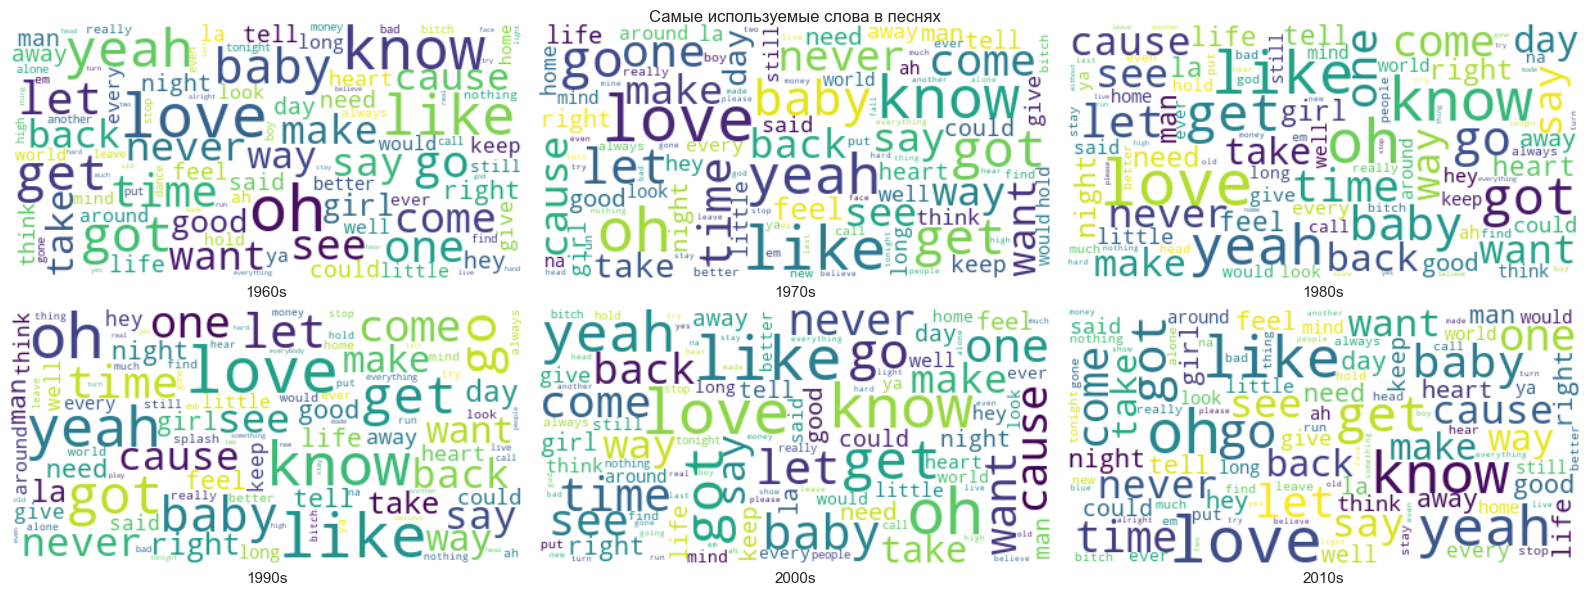

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

for i, ax in zip(range(tracks_cv.columns[1:].size), axes.flat):
    plot_wordcloud(ax, tracks_cv, tracks_cv.columns[1:][i])

plt.tight_layout()
plt.suptitle('Самые используемые слова в песнях')

Получили облака из наиболее используемых слов в песнях по декадам. Бросается в глаза, что песни, в основном, имеют романтическую тематику.

Попробуем избавиться от всех частей речи, кроме существительных.

In [25]:
tags = nltk.pos_tag(tracks_cv['words'])
nouns = [word for word, pos in tags if pos[:2] == 'NN']

nouns_df_cv = tracks_cv[tracks_cv['words'].isin(nouns)]

Text(0.5, 0.98, 'Самые используемые слова в песнях')

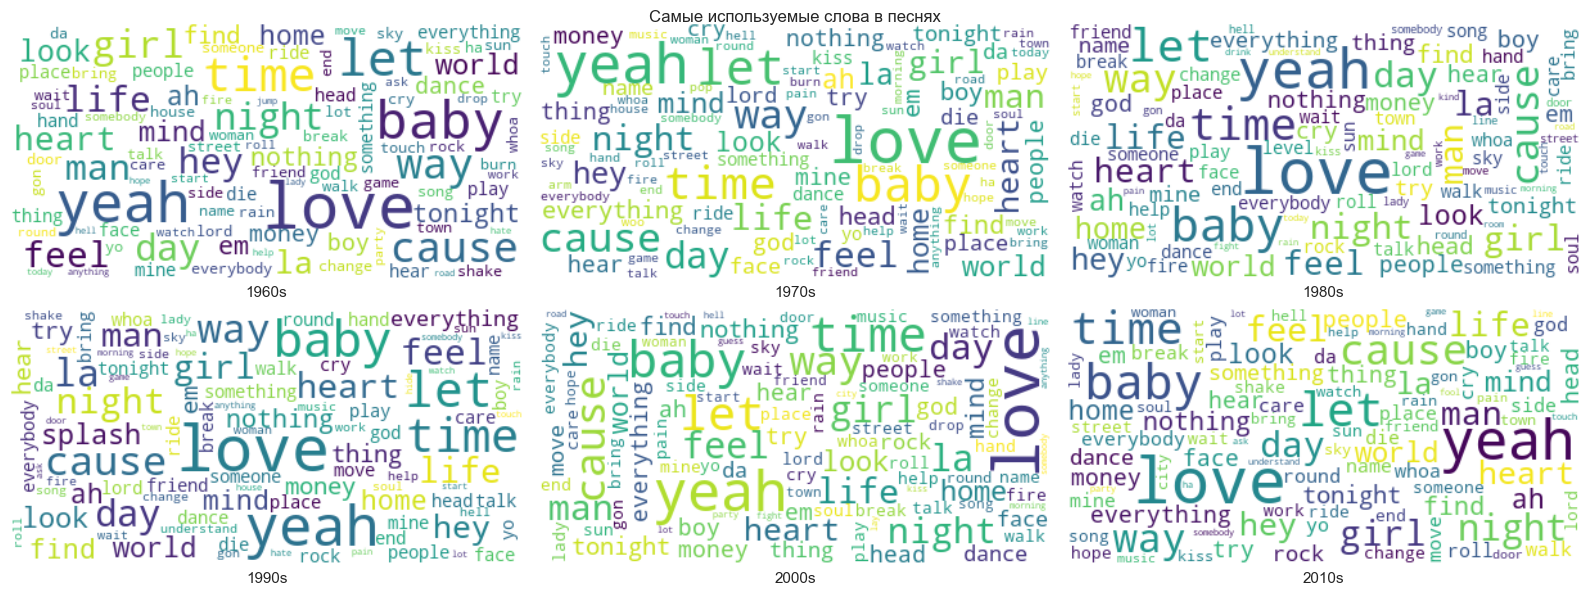

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

for i, ax in zip(range(nouns_df_cv.columns[1:].size), axes.flat):
    plot_wordcloud(ax, nouns_df_cv, nouns_df_cv.columns[1:][i])

plt.tight_layout()
plt.suptitle('Самые используемые слова в песнях')

In [27]:
def print_top_10_words(decade):
    return nouns_df_cv.sort_values(decade, ascending=False)[['words', decade]].head(10)

Теперь построю гистограмму с частотностью использования слов, которые встречаются в топ-10 всех декад.

In [28]:
top_60s = print_top_10_words('1960s')
top_70s = print_top_10_words('1970s')
top_80s = print_top_10_words('1980s')
top_90s = print_top_10_words('1990s')
top_2000s = print_top_10_words('2000s')
top_2010s = print_top_10_words('2010s')

In [29]:
intersection = np.intersect1d(top_60s['words'], top_70s['words'])
intersection = np.intersect1d(intersection, top_80s['words'])
intersection = np.intersect1d(intersection, top_90s['words'])
intersection = np.intersect1d(intersection, top_2000s['words'])
intersection = np.intersect1d(intersection, top_2010s['words'])
intersection

array(['baby', 'cause', 'let', 'love', 'time', 'way', 'yeah'],
      dtype=object)

In [30]:
top_df_cv = nouns_df_cv[nouns_df_cv['words'].isin(intersection)]
top_df_cv = top_df_cv[top_df_cv['words'].isin(['baby', 'time', 'love', 'yeah', 'day'])]

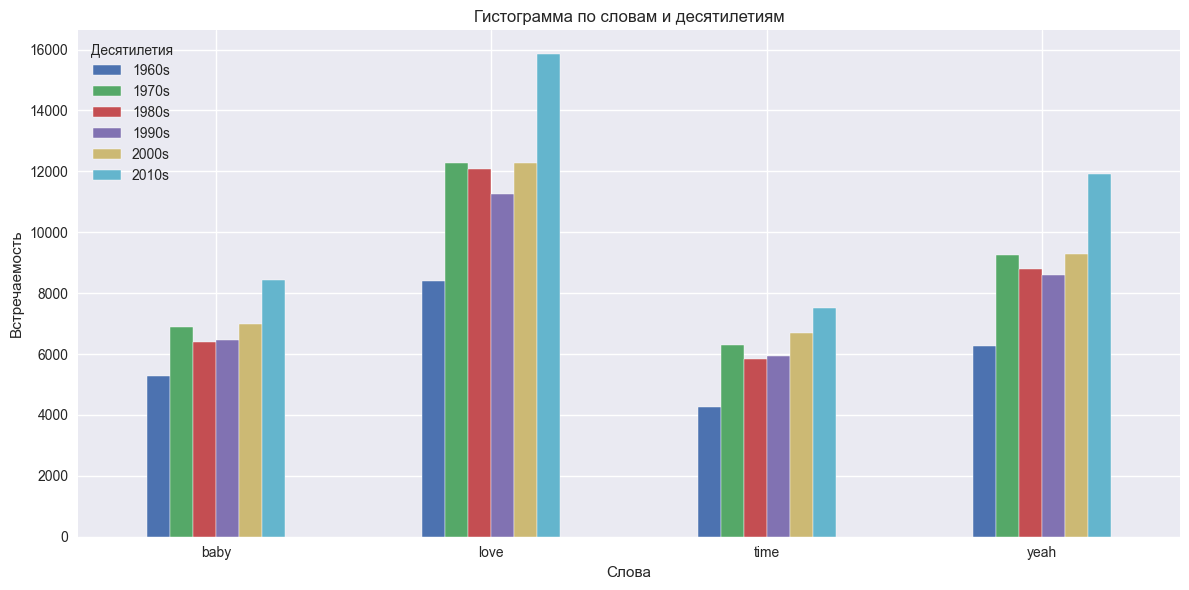

In [31]:
top_df_cv.set_index('words').plot(kind='bar', figsize=(12, 6))
plt.title('Гистограмма по словам и десятилетиям')
plt.xlabel('Слова')
plt.ylabel('Встречаемость')
plt.legend(title='Десятилетия')
plt.xticks(rotation=0)
plt.tight_layout()

Видна тенденция на увелечения использования слов с течением времени, при чем во всех группах.

### Анализ признаков от Spotify

Spotify API предоставляет большой список признаков, которые могут быть у песни. Полный список находится в [документации](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Для примера я решил рассмотреть 4 признака:

| danceability                                                          | loudness                                                                  | acousticness                                           | instrumentalness                                                                                                                            |
|-----------------------------------------------------------------------|---------------------------------------------------------------------------|--------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| Оценивает танцевальность трека<br/> от 0 до 1 на основе темпа и ритма | Средняя громкость трека в децибелах (дБ),<br/> усредненная по всему треку | Оценка уверенности от 0 до 1<br/> в акустичности трека | Определяет, содержит ли трек вокал. <br/>Значение инструментальности от 0 до 1: чем ближе к 1, <br/>тем выше вероятность отсутствия вокала. |

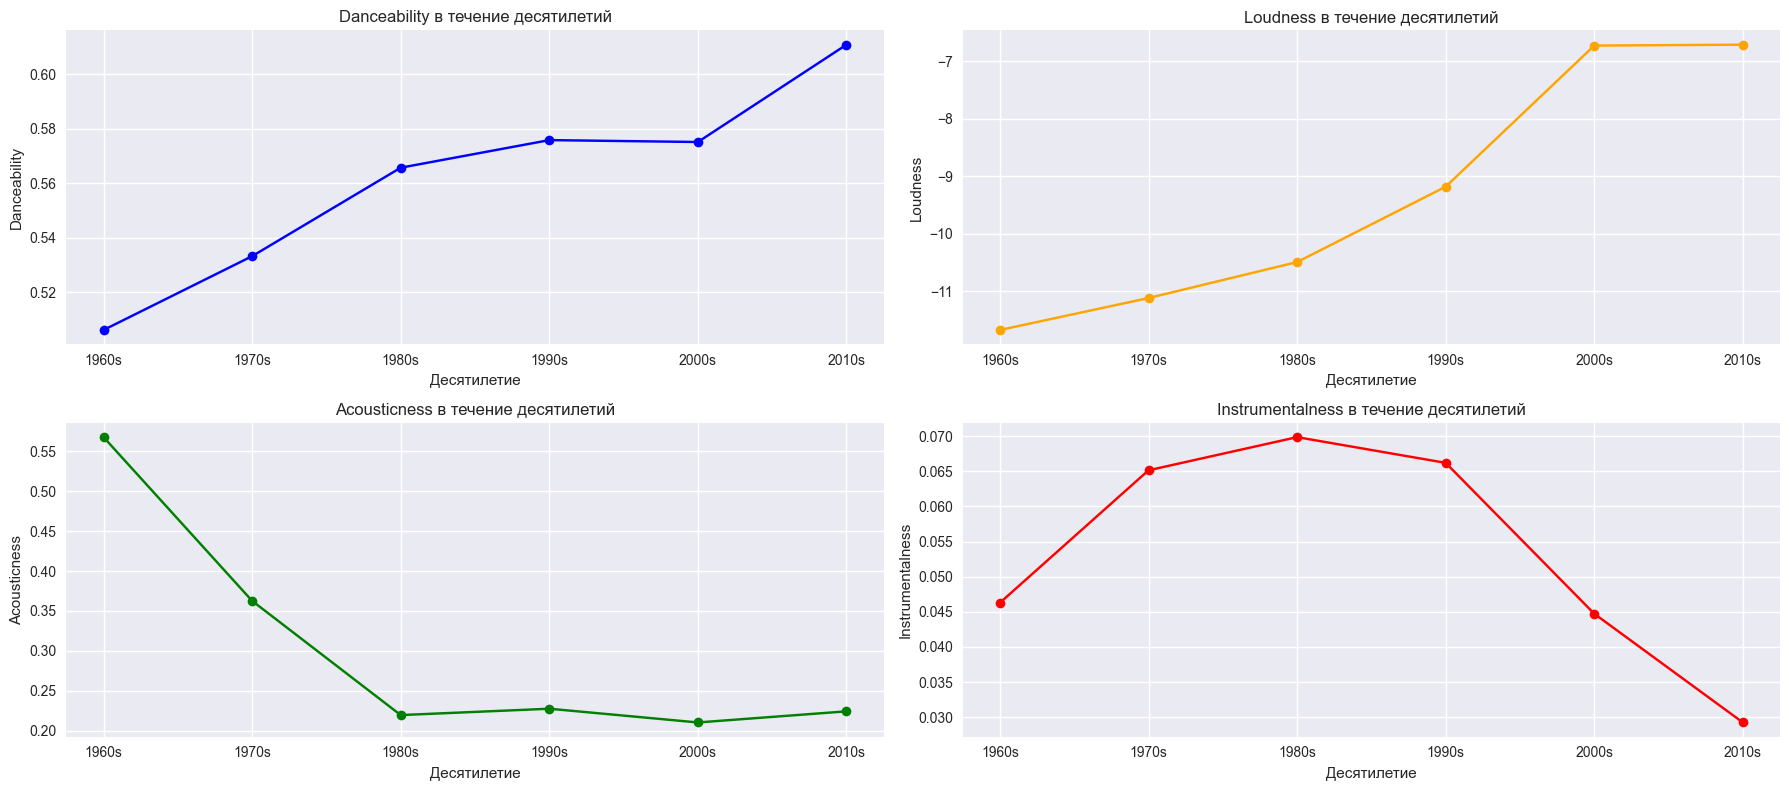

In [32]:
trends = decade_tracks_df.groupby('decade')[
    ['danceability', 'loudness', 'acousticness', 'instrumentalness']].mean().reset_index()

features = ['danceability', 'loudness', 'acousticness', 'instrumentalness']
titles = ['Danceability в течение десятилетий', 'Loudness в течение десятилетий',
          'Acousticness в течение десятилетий', 'Instrumentalness в течение десятилетий']
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(18, 8))

for i, (feature, title, color) in enumerate(zip(features, titles, colors), start=1):
    plt.subplot(2, 2, i)
    plt.plot(trends['decade'], trends[feature], marker='o', color=color)
    plt.title(title)
    plt.xlabel('Десятилетие')
    plt.ylabel(feature.capitalize())

plt.tight_layout()

Делаем вывод:
- Танцевальность и громкость треков имеют неуклонный рост в течением времени
- Акустичность и инструментальность становятся ниже, вероятно, ввиду огромной популярности реп-музыки.

### Классификация песен по жанрам

Зададимся вопросом — достаточно ли признаков от Spotify, описывающих песню, для классификации песен по жанрам? Также стоит отметить, что в исходном датасете не все песни размечены жанром. Эту проблему будем решать отдельно при помощи **semi-supervised** кластеризации на основе KMeans.

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [34]:
genres_df = genres_df[['track_id', 'genre']]

genres_decade_tracks_df = decade_tracks_df.merge(genres_df, how='left', left_on='id', right_on='track_id').drop(
    'track_id', axis=1)
genres_decade_tracks_df = genres_decade_tracks_df[genres_decade_tracks_df['decade'] != '2020s'].groupby('decade').apply(
    lambda x: x.head(10000)).reset_index(drop=True)

genres_decade_tracks_df['norm_tempo'] = scaler.fit_transform(genres_decade_tracks_df[['tempo']])
genres_decade_tracks_df = genres_decade_tracks_df.replace('Children’s Music', 'Children\'s Music')

In [35]:
known_data = genres_decade_tracks_df[genres_decade_tracks_df['genre'].notna()]
unknown_data = genres_decade_tracks_df[genres_decade_tracks_df['genre'].isna()]

In [36]:
print('Доля песен с известным жанром: ', f'{int(round(max(known_data.shape) / max(genres_decade_tracks_df.shape), 2) * 100)}%')

Доля песен с известным жанром:  44%


Жанров много, поэтому оставлю только часто встречаемые

In [37]:
genre_value_counts = known_data['genre'].value_counts()
genres = genre_value_counts[genre_value_counts >= 1000].index

df = known_data[known_data['genre'].isin(genres)]

In [38]:
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence']]
y = df['genre']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial'),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "AdaBoost": AdaBoostClassifier(),
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name}: Средняя точность = {scores.mean():.4f}")

Logistic Regression: Средняя точность = 0.2113
Random Forest: Средняя точность = 0.1384
SVM: Средняя точность = 0.1786
AdaBoost: Средняя точность = 0.1978


Наилучший результат показала логистическая регрессия. Попробуем подобрать наилучшие гиперпараметры для нее.

In [40]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.5, 1],
    'multi_class': ['auto', 'multinomial']
}

log_reg = LogisticRegression()
clf = GridSearchCV(log_reg, parameters)

clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1], 'multi_class': ['auto', 'multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [41]:
accuracy_score(y_test, clf.best_estimator_.predict(X_test))

0.2250105440742303

Результат улучшился, но незначительно. Вывод — текущих данных и / или признаков **недостаточно** для достойной
классификации. Будем пытаться поднимать точность

### Кластеризация песен по жанрам

Я упомянул выше, что большая часть песен в датасете не имеет размеченного жанра. К тому же, для классификации хочется использовать больше признаков, чтобы помочь модели правильно ее проводить. Я хочу задействовать еще текст песен.

Какие есть способы конвертировать текст во что-то численное? Я подобрал 4 подхода:
- **TF-IDF**: Примитивный подход, который никак не учитывает контекст используемых слов. Для работы с текстом песен такой подход **не подойдет**.
- **Word2Vec**: Обучается на отдельных словах, создавая векторы для каждого слова на основе его контекста в предложении. Применяется для задач, связанных с анализом слов.
- **Doc2Vec**: Расширенная модель Word2Vec, которая работает с целыми документами и используется для задач классификации текстов
- **Top2Vec**: Одновременно учитывает как тематику (топики), так и семантическую информацию из текста. Позволяет находить ключевые темы в коллекции документов и анализировать их взаимосвязи

В итоге я выбрал модель **Top2Vec** за ее возможности семантического анализа.

#### Top2Vec

In [42]:
vocabulary = genres_decade_tracks_df['clean_lyrics']
vocabulary = vocabulary.apply(lambda x: x.split(' '))

In [43]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [44]:
from top2vec import Top2Vec

model = Top2Vec(documents=list(vocabulary.apply(lambda x: ' '.join(x)).to_numpy()), speed="learn", workers=cores)

model.get_num_topics()

2025-01-30 22:27:21,800 - top2vec - INFO - Pre-processing documents for training
2025-01-30 22:27:33,437 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2025-01-30 22:27:34,678 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-01-30 22:32:07,671 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-01-30 22:32:51,242 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-01-30 22:32:56,727 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


498

In [45]:
top2vec_vectors = model.document_vectors
top2vec_vectors.shape

(60000, 512)

Продемонстрирую поиск документов (== текстов песен) по ключевым словам.

In [46]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=['human'], num_docs=3)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 48068, Score: 0.4772826017196238
-----------
human much common human much common human much common human much common human much common human much common human much common human much common human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human human
-----------

Document: 36039, Score: 0.4449134089153374
-----------
ever get close human human behaviour ready ready get confused hereafter definitely definitely definitel

In [47]:
keywords = ['love', 'hate', 'passion', 'sadness']
result = []

for keyword in keywords:
    words, word_scores = model.similar_words(keywords=[keyword], keywords_neg=[], num_words=10)
    for word, score in zip(words, word_scores):
        result.append((keyword, word, score))

In [48]:
pd.DataFrame(result, columns=['keyword', 'word', 'score']).groupby(['keyword']).apply(display)

keyword        word     score
10    hate       hater  0.927074
11    hate      hatred  0.911847
12    hate     despise  0.862534
13    hate  despicable  0.758435
14    hate         hat  0.757118
15    hate    wretched  0.722236
16    hate       badly  0.716882
17    hate         bad  0.715091
18    hate    disgrace  0.709222
19    hate     pitiful  0.707119

keyword        word     score
0    love        amor  0.915544
1    love      loving  0.911070
2    love       amour  0.903546
3    love     beloved  0.829440
4    love       lover  0.781761
5    love       adore  0.781034
6    love      liking  0.756761
7    love   affection  0.755828
8    love      lovely  0.727643
9    love  sweetheart  0.717411

keyword        word     score
20  passion  passionate  0.925982
21  passion      loving  0.733282
22  passion      thrill  0.723652
23  passion     emotion  0.705340
24  passion  excitement  0.703491
25  passion    exciting  0.697690
26  passion        love  0.686059
27  passion      liking  0.678161
28  passion      excite  0.675028
29  passion       amour  0.666106

keyword        word     score
30  sadness         sad  0.905270
31  sadness    grieving  0.806971
32  sadness       grief  0.778198
33  sadness      grieve  0.772710
34  sadness      sorrow  0.744095
35  sadness     despair  0.741537
36  sadness    mourning  0.740991
37  sadness   miserable  0.739053
38  sadness  bitterness  0.737443
39  sadness       mourn  0.735023

Empty DataFrame
Columns: []
Index: []

Библиотека, предоставляющая Top2Vec, может из коробки строить облака слов из топиков, которые также задаются через ключевые слова. Вот пример:

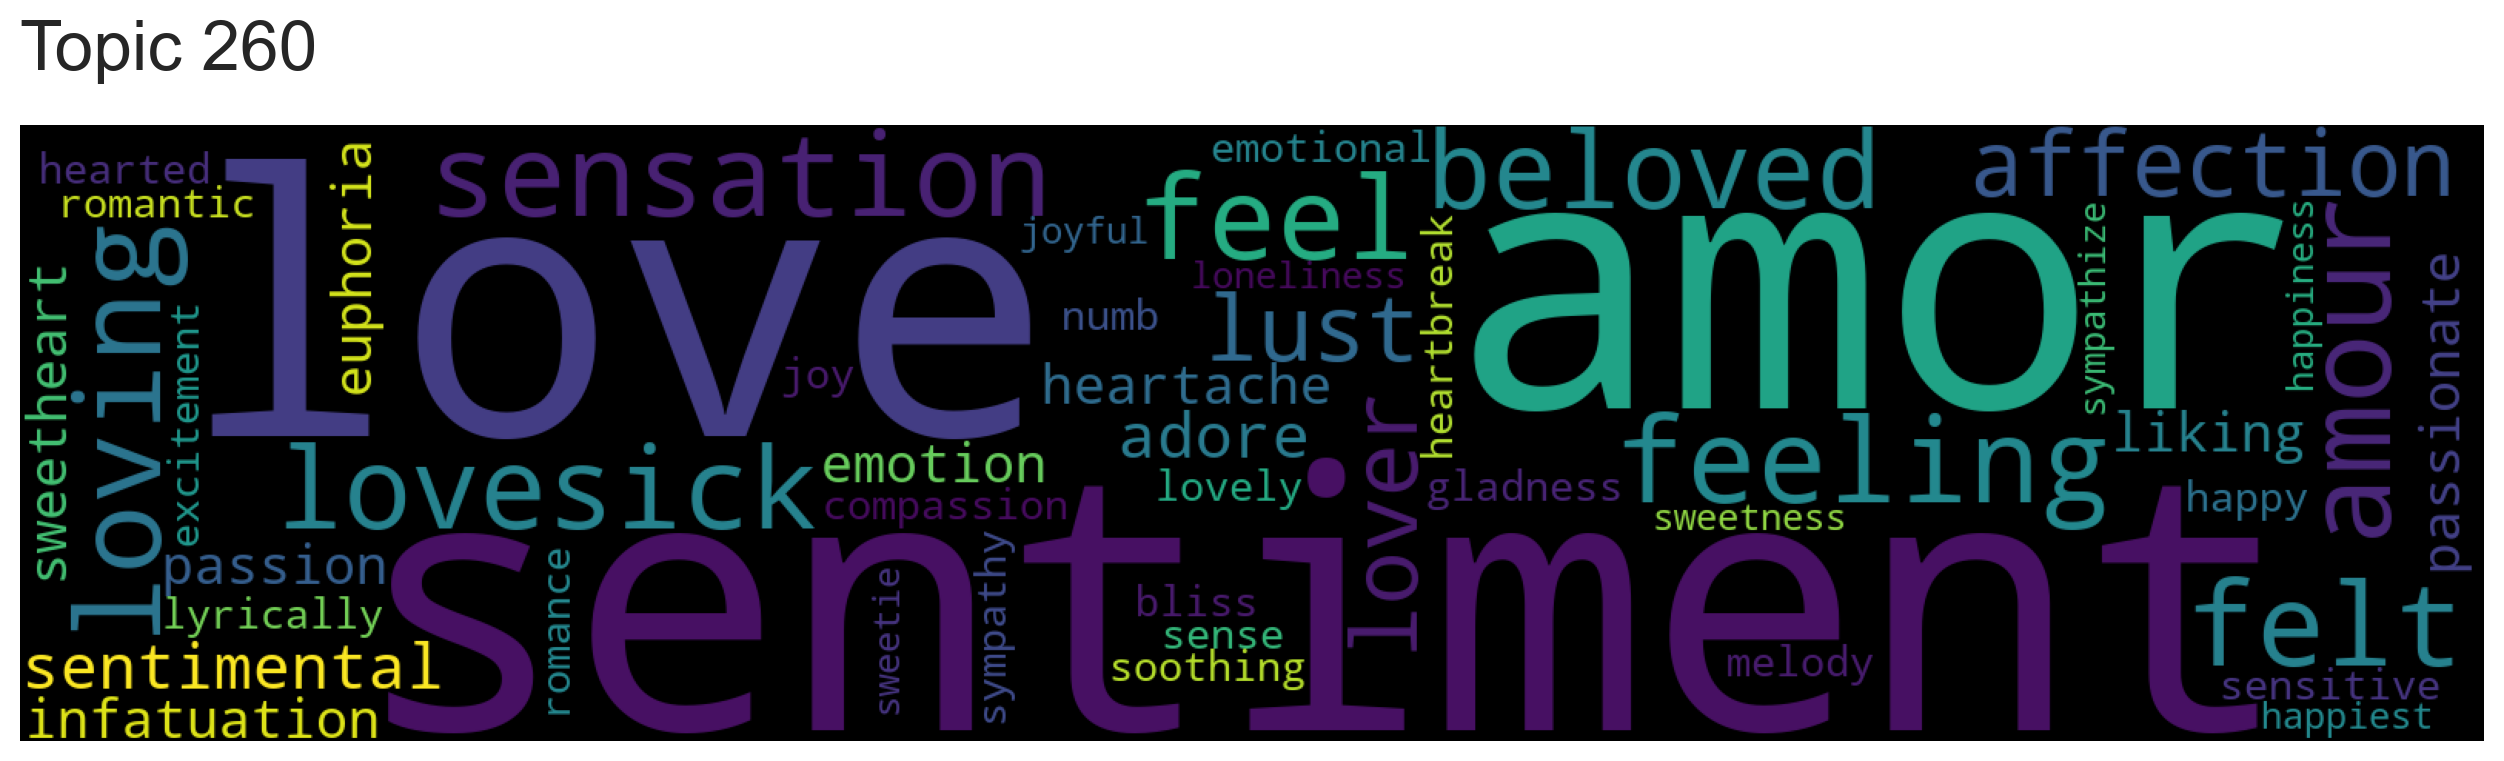

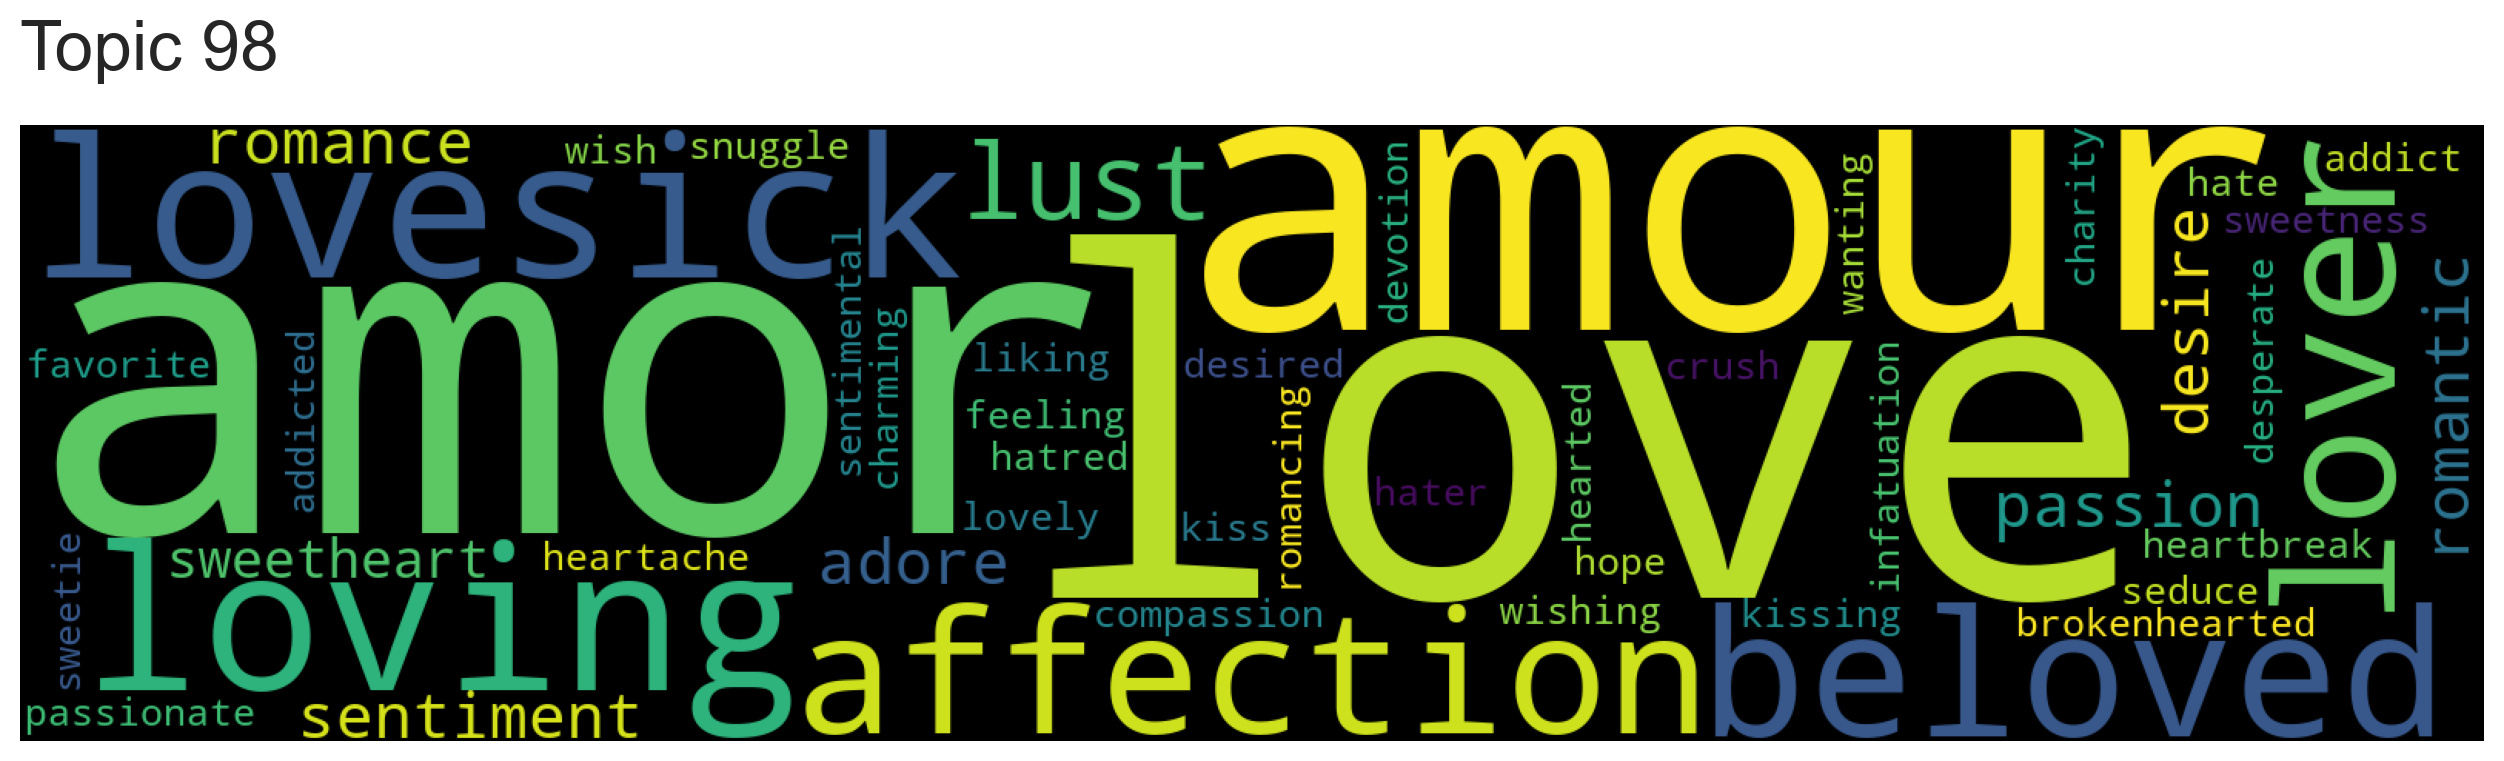

In [49]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["love"], num_topics=2)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

Теперь же сформирую DataFrame из векторизированных представлений документов, который буду использовать для дальнейшей кластеризации.

In [50]:
top2vec_df = pd.DataFrame(top2vec_vectors)
top2vec_df = top2vec_df.add_prefix('doc_vec_')
top2vec_df.head()

doc_vec_0  doc_vec_1  doc_vec_2  doc_vec_3  doc_vec_4  doc_vec_5  \
0   0.004493   0.029277  -0.068898  -0.058884  -0.019410   0.063909   
1   0.047717  -0.058881   0.031027  -0.031727  -0.015371   0.019715   
2   0.061505  -0.029557   0.002723  -0.043087  -0.041923   0.051973   
3   0.061633  -0.037214   0.005162  -0.042776  -0.038377   0.054431   
4   0.059825   0.016812  -0.014672  -0.007085  -0.008729   0.026444   

   doc_vec_6  doc_vec_7  doc_vec_8  doc_vec_9  ...  doc_vec_502  doc_vec_503  \
0   0.035581   0.050427  -0.001610   0.057742  ...    -0.011599    -0.017088   
1  -0.015873  -0.030370   0.005580   0.039871  ...     0.043175     0.005923   
2   0.003841  -0.019263  -0.052150   0.044463  ...     0.056997     0.019408   
3   0.010117  -0.014939  -0.053083   0.043834  ...     0.057060     0.022229   
4  -0.031301   0.019753   0.038973   0.022907  ...     0.039161    -0.017428   

   doc_vec_504  doc_vec_505  doc_vec_506  doc_vec_507  doc_vec_508  \
0    -0.048368    -0.014148    -0.033210    -0.023081    -0.064695   
1    -0.076096     0.017231     0.033255     0.006038     0.044574   
2    -0.061572    -0.037486     0.022973    -0.013380     0.028127   
3    -0.061703    -0.035142     0.016330    -0.011887     0.032502   
4    -0.068938     0.050933     0.007862    -0.012781    -0.046063   

   doc_vec_509  doc_vec_510  doc_vec_511  
0     0.004785     0.052084     0.047503  
1    -0.006373     0.034585    -0.039232  
2    -0.061326     0.060416    -0.035134  
3    -0.061425     0.060639    -0.032043  
4    -0.061352     0.028072    -0.014322  

[5 rows x 512 columns]

#### Объединение данных

In [51]:
genres_decade_tracks_df_text = pd.concat(
    [genres_decade_tracks_df.reset_index(drop=True), top2vec_df.reset_index(drop=True)], axis=1)

In [52]:
genres_decade_tracks_df_text['genre'].unique()

array([nan, 'Folk', 'Soul', 'Rock', 'Blues', 'Jazz', 'Reggae', 'Ska',
       'Country', 'World', 'Pop', 'Dance', 'Classical', 'Movie',
       'Soundtrack', 'Alternative', 'Indie', 'Electronic',
       "Children's Music", 'Comedy', 'R&B', 'Hip-Hop', 'Rap', 'Anime',
       'Reggaeton', 'Opera'], dtype=object)

In [53]:
known_data = genres_decade_tracks_df_text[genres_decade_tracks_df_text['genre'].notna()]
unknown_data = genres_decade_tracks_df_text[genres_decade_tracks_df_text['genre'].isna()]

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
            'norm_tempo', 'valence', 'mode', 'key', 'explicit'] + top2vec_df.columns.tolist()

In [54]:
known_data['genre'].unique()

array(['Folk', 'Soul', 'Rock', 'Blues', 'Jazz', 'Reggae', 'Ska',
       'Country', 'World', 'Pop', 'Dance', 'Classical', 'Movie',
       'Soundtrack', 'Alternative', 'Indie', 'Electronic',
       "Children's Music", 'Comedy', 'R&B', 'Hip-Hop', 'Rap', 'Anime',
       'Reggaeton', 'Opera'], dtype=object)

Поскольку мне известна часть данных о жанрах, я воспользуюсь **semi-supervised** кластеризацией. Это подход, который использует небольшое количество размеченных данных (то есть данных с известными метками) вместе с большим объемом неразмеченных данных (данных без меток) для улучшения качества кластеризации. Для этого я использую алгоритм **KMeans**

In [55]:
all_data = genres_decade_tracks_df_text[features]

initial_centroids = known_data.groupby('genre')[features].mean().values
n_clusters = len(known_data['genre'].unique())

In [56]:
from sklearn.cluster import KMeans

kmeans_genre = KMeans(n_clusters, init=initial_centroids)

In [57]:
clusters = kmeans_genre.fit_predict(all_data)

known_cluster_labels = clusters[:len(known_data)]
unknown_cluster_labels = clusters[len(known_data):]

Оценим результат кластеризации с помощью [коэффициента силуэта](https://wiki.loginom.ru/articles/cluster-silhouette-index.html)

In [58]:
from sklearn.metrics import silhouette_score

silhouette_score(all_data, clusters)

0.1795066489949624

Довольно низкий результат. Теперь интересно посмотреть на график этой кластеризации

In [59]:
cluster_to_genre = {}
for cluster in range(n_clusters):
    cluster_genres = known_data[clusters[known_data.index] == cluster]['genre']
    most_common_genre = cluster_genres.value_counts().idxmax()
    cluster_to_genre[cluster] = most_common_genre

In [60]:
unknown_data['genre'] = [cluster_to_genre[label] for label in unknown_cluster_labels]

In [61]:
all_data.shape

(60000, 524)

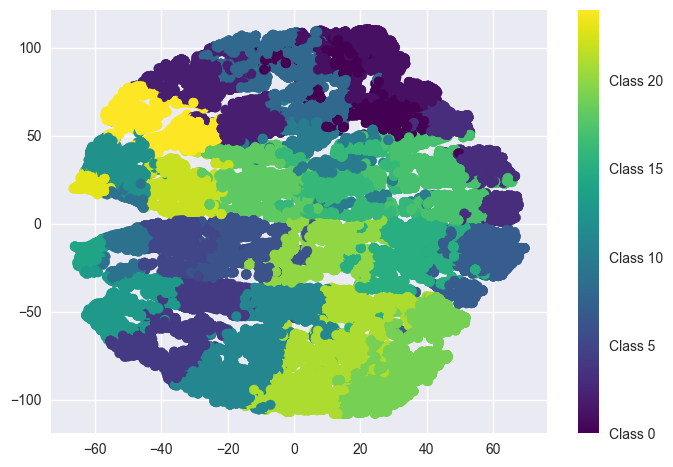

In [62]:
from openTSNE.sklearn import TSNE

tsne_genre = TSNE(perplexity=150).fit_transform(all_data.to_numpy())
sc = plt.scatter(tsne_genre[:, 0], tsne_genre[:, 1], c=clusters, cmap='viridis')
plt.colorbar(sc, format=f'Class %i')

Видим, что нет никаких явных облаков кластеров. Получившийся результат различим только благодаря раскраске классов. Делаем вывод, что обработанных признаков **недостаточно** для качественной кластеризации.

### Анализ трендов по жанрам песен

<Axes: >

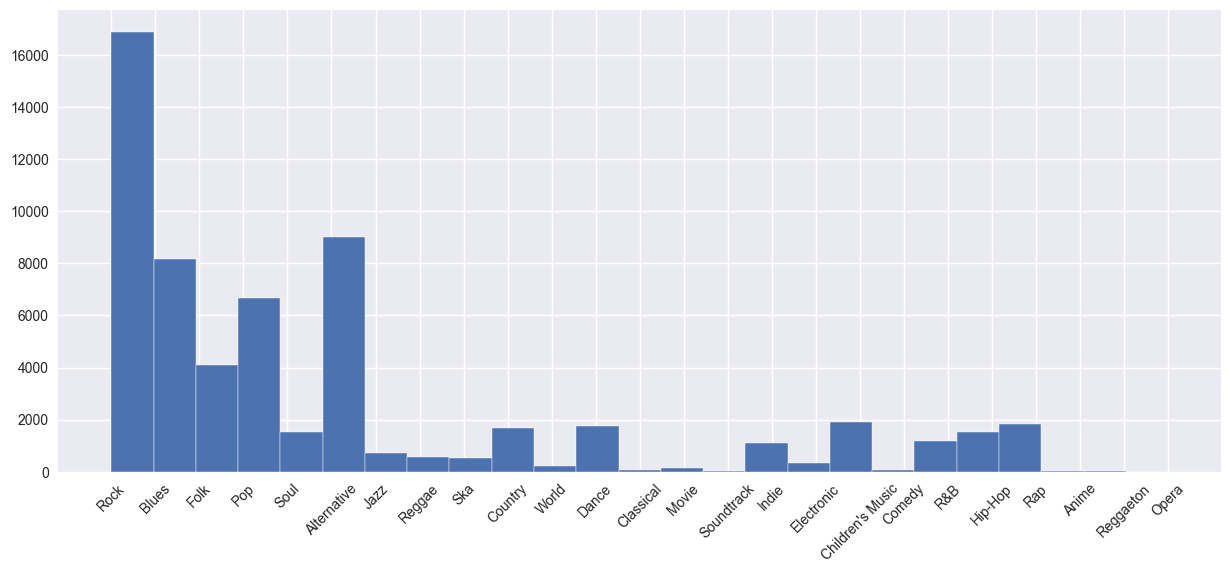

In [63]:
genres_decade_tracks_df_text['genre'] = pd.concat([known_data, unknown_data])['genre']
genres_decade_tracks_df['genre'] = genres_decade_tracks_df_text['genre']
genres_decade_tracks_df['genre'].hist(figsize=(15, 6), xrot=45, bins=25)

Имеем следующее распределение жанров. В целом — выглядит более-менее. Теперь выберу часть жанров, не похожих друг на друга, и сравню тренды в них

In [64]:
top_genres = ['Rock', 'Pop', 'Folk', 'Soul', 'Rap']

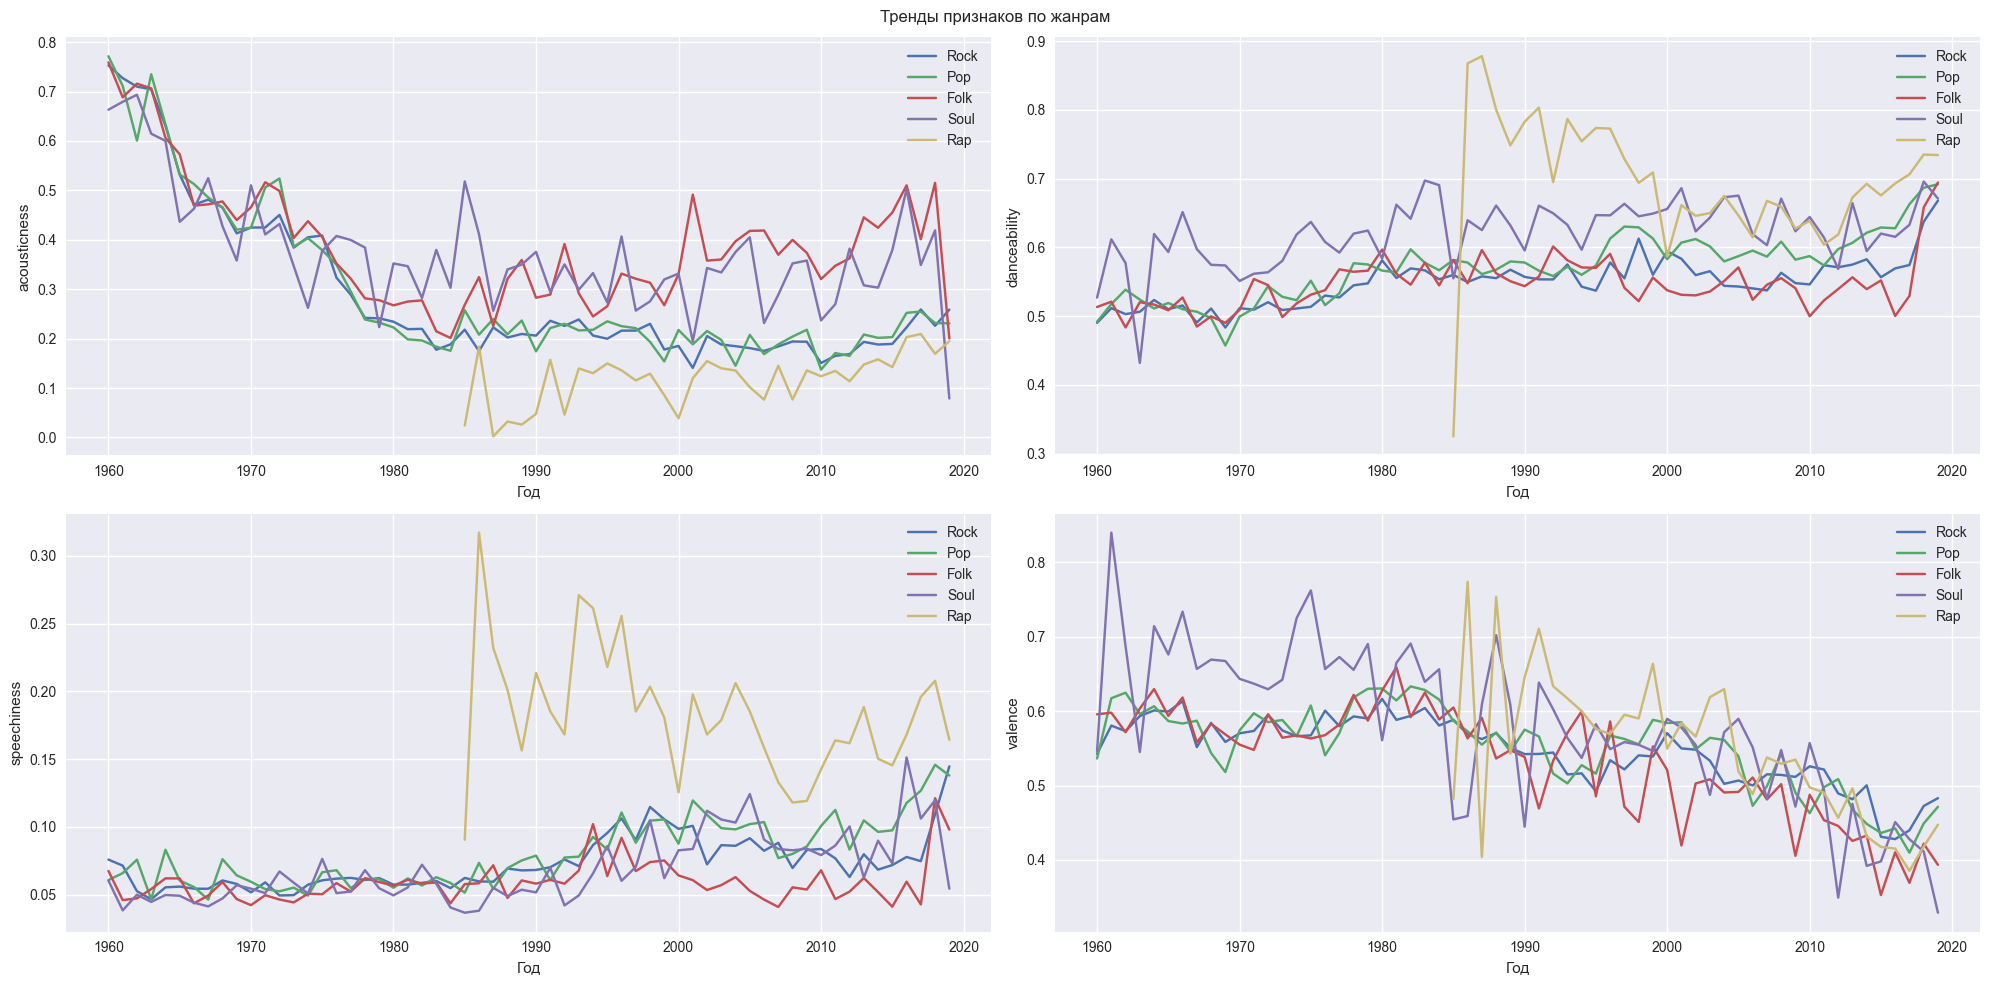

In [65]:
features = ['acousticness', 'danceability', 'speechiness', 'valence']
trends = genres_decade_tracks_df.groupby(['genre', 'year'])[features].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for genre in top_genres:
    for i, ax in zip(range(len(features)), axes.flat):
        ax.plot(trends[trends['genre'] == genre]['year'], trends[trends['genre'] == genre][features[i]])
        ax.set_xlabel('Год')
        ax.set_ylabel(features[i])
        ax.legend(top_genres)

plt.suptitle('Тренды признаков по жанрам')
plt.tight_layout()

#### Sentiment Analysis

Sentiment Analysis — процесс анализа текста для определения того, является ли эмоциональный тон сообщения положительным, отрицательным или нейтральным.

Попробуем определять настроение песен по тексту. Для этого я взял [BERT-based](https://huggingface.co/blog/bert-101) [модель](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) из сервиса HuggingFace.

In [66]:
from transformers import pipeline

classification = pipeline('sentiment-analysis', model='bhadresh-savani/distilbert-base-uncased-emotion')

Device set to use mps:0


In [67]:
classification(genres_decade_tracks_df['lyrics'][1])

[{'label': 'joy', 'score': 0.9935901165008545}]

In [68]:
genres_decade_tracks_df['sentiment'] = genres_decade_tracks_df['lyrics'].apply(
    lambda x: classification(x[:512])[0]['label'])

<Axes: >

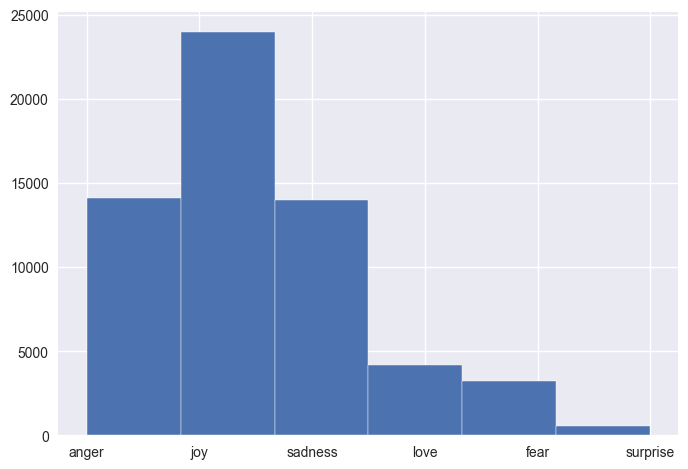

In [69]:
genres_decade_tracks_df['sentiment'].hist(bins=6)

Получили гистограмму с распределением настроений, передаваемых текстами песен в моем датасете.

In [70]:
sentiments = genres_decade_tracks_df['sentiment'].unique()
sentiments

array(['anger', 'joy', 'sadness', 'love', 'fear', 'surprise'],
      dtype=object)

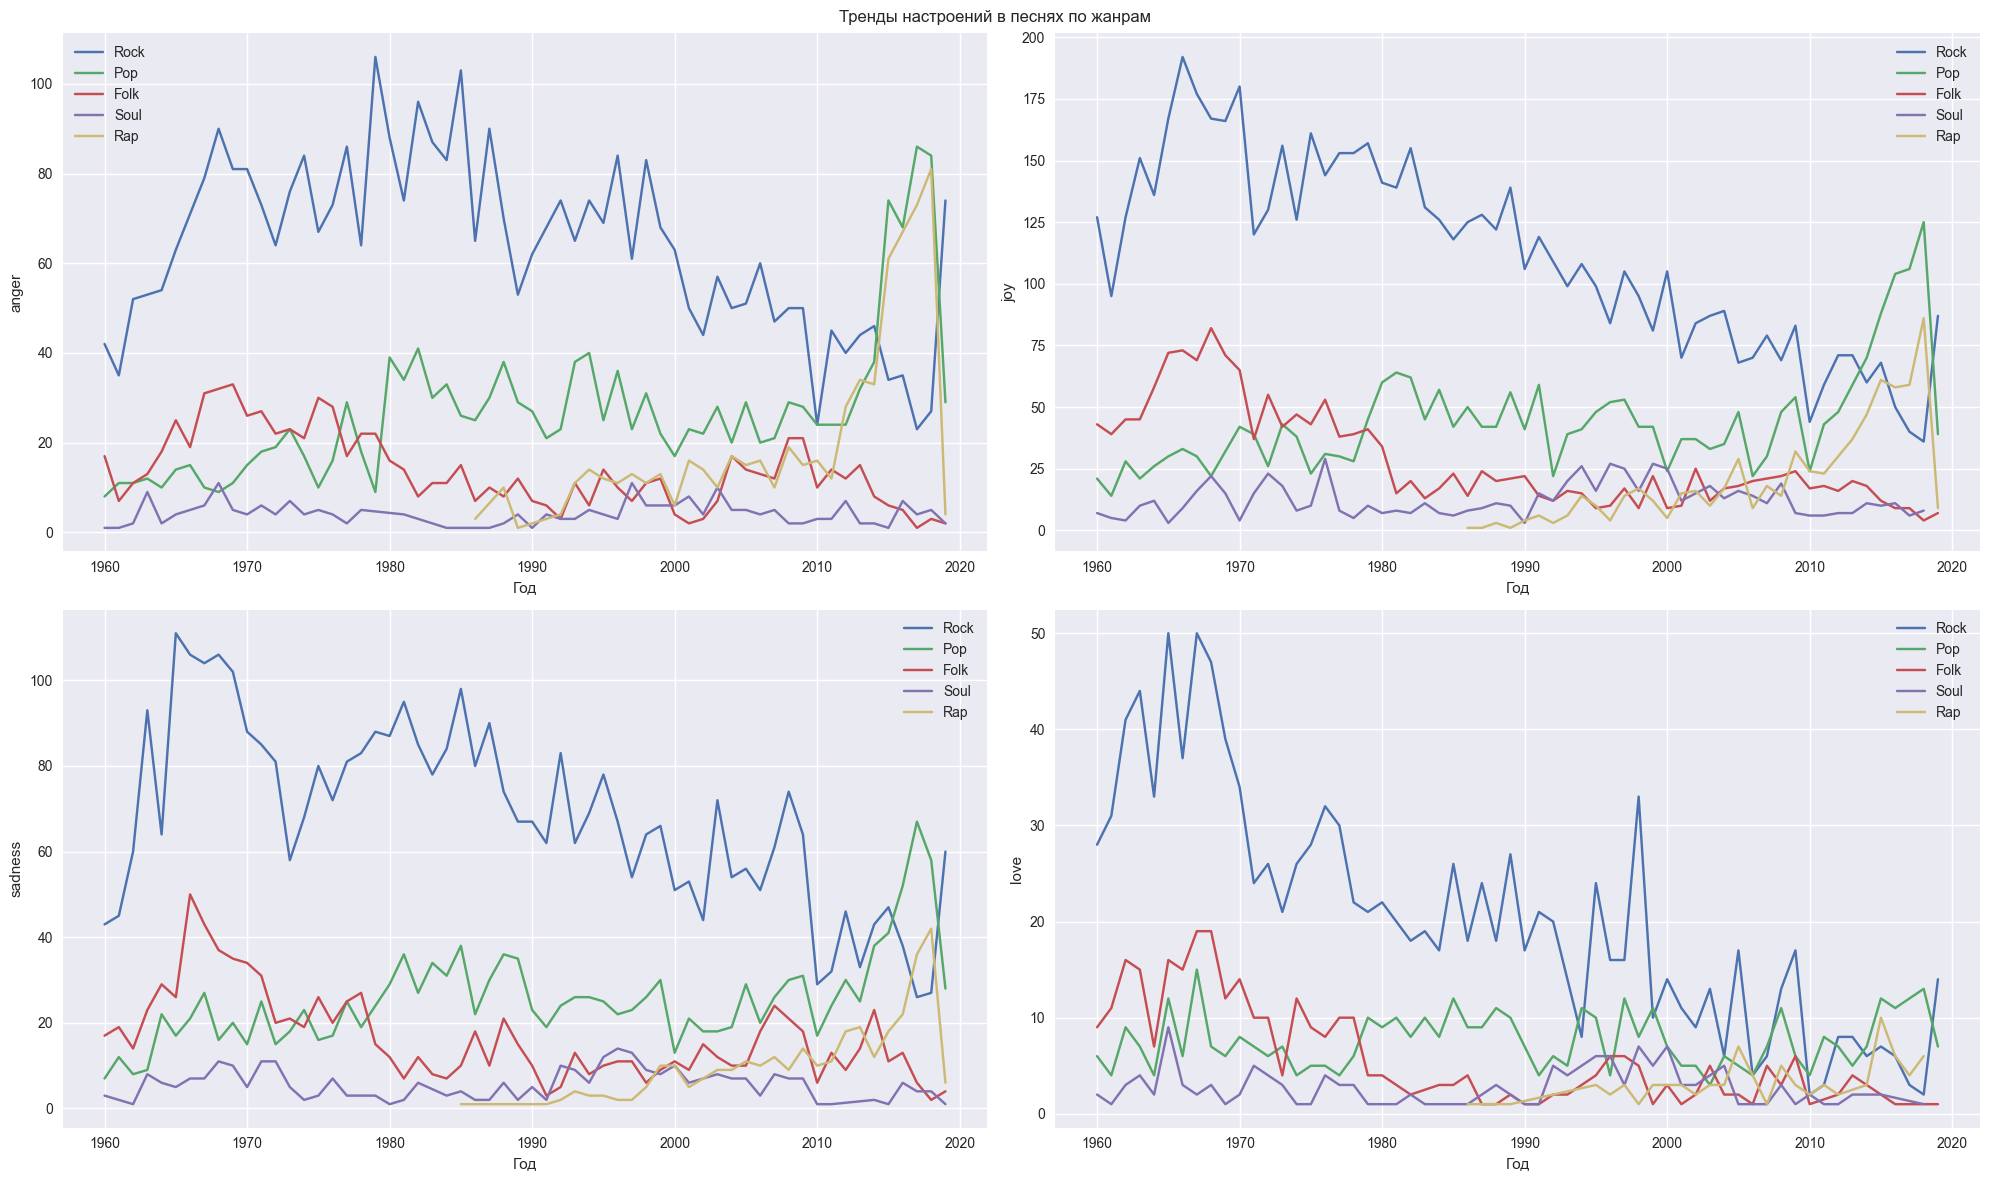

In [71]:
trends = genres_decade_tracks_df.groupby(['genre', 'year', 'sentiment'])[
    ['year', 'sentiment', 'genre']].value_counts().reset_index()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

for genre in top_genres:
    for i, ax in zip(range(len(sentiments[:4])), axes.flat):
        sentiment = sentiments[i]
        ax.plot(
            trends[(trends['genre'] == genre) & (trends['sentiment'] == sentiment)]['year'],
            trends[(trends['genre'] == genre) & (trends['sentiment'] == sentiment)]['count'],
        )
        ax.set_xlabel('Год')
        ax.set_ylabel(sentiment)
        ax.legend(top_genres)

plt.suptitle('Тренды настроений в песнях по жанрам')
plt.tight_layout()

Видно, что у треков есть тенденция на снижение радости и любви в текстах, а агрессия, наоборот, увеличивается. Думайте.

## Анализ аудио

Развивающееся направление в глубоком обучении. Много применений — рекомендации, поиск сходства аудио, обработка и синтез речи.

### Глоссарий

**Виды частот:**
- Низкие частоты — до 500 Гц (бас)
- Средние частоты — 500-3000 Гц (речь человека, фортепиано и гитара)
- Высокие частоты — 3000-8000 Гц (свист, пение птиц, женский вокал)
- Сверхвысокие частоты — выше 8000 Гц (шум ветра, высокие гармоники скрипки или флейты)

**Спектрограмма** — это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, присутствующих в форме волны. Обычно изображается в виде тепловой карты.

**MFCC (Мел-кепстральные коэффициенты)** — это компактное представление спектра аудиосигнала. Коэффициенты MFCC содержат информацию об изменении частоты в различных полосах спектра.

### Пример получение аудиоданных

In [72]:
mfcc_audio_df = low_level_audio_df.filter(regex='(MFCC_)|(track_id)', axis=1)
mfcc_audio_df = mfcc_audio_df.merge(genres_decade_tracks_df, how='left', left_on='track_id',
                                    right_on='id').dropna().drop_duplicates(subset=['id'])

mfcc_columns = mfcc_audio_df.filter(regex='(MFCC_)|(track_id)', axis=1)
other_columns = mfcc_audio_df[['name', 'artists', 'year', 'duration_ms', 'year', 'genre', 'norm_tempo', 'sentiment']]

mfcc_audio_df = pd.concat([mfcc_columns, other_columns], axis=1)
mfcc_audio_df = mfcc_audio_df.reset_index().rename(columns={'index': 'song_id'})
mfcc_audio_df = mfcc_audio_df.loc[:, ~mfcc_audio_df.columns.duplicated()].copy()
mfcc_audio_df['year'] = mfcc_audio_df['year'].astype(int)

В качестве примера рассмотрим два трека:
- **Paranoid** от Black Sabbath, рок, 1970 год
- **Mr. Tambourine Man** от Боба Дилана, фолк, 1965 год

Каждый из треков — короткий 10 секундтный отрывок в формате `.mp3`

In [105]:
rock_song = mfcc_audio_df[mfcc_audio_df['track_id'] == '1Y373MqadDRtclJNdnUXVc']  # Black Sabbath — Paranoid
rock_song_file = 'semester-1/demo_audio/Black-Sabbath-Paranoid-Trim.mp3'

folk_song = mfcc_audio_df[mfcc_audio_df['track_id'] == '3RkQ3UwOyPqpIiIvGVewuU']  # Bob Dylan — Mr. Tambourine Man
folk_song_file = 'semester-1/demo_audio/Bob-Dylan-Mr-Tambourine-Trim.mp3'

In [106]:
rock_song

song_id      MFCC_1   MFCC_10   MFCC_11  MFCC_12   MFCC_13   MFCC_14  \
1355    45114 -153.419671  2.890009  7.239889  3.49663  5.824975  3.177899   

       MFCC_15   MFCC_16   MFCC_17  ...    MFCC_8    MFCC_9  \
1355  5.732102 -2.647939  5.070436  ...  3.702767  3.255779   

                    track_id                      name            artists  \
1355  1Y373MqadDRtclJNdnUXVc  Paranoid - 2016 Remaster  ['Black Sabbath']   

      year  duration_ms  genre  norm_tempo  sentiment  
1355  1970     168406.0   Rock    1.452886        joy  

[1 rows x 57 columns]

In [107]:
folk_song

song_id      MFCC_1   MFCC_10   MFCC_11   MFCC_12   MFCC_13  MFCC_14  \
121     3320 -205.902479 -4.373218  2.227024 -0.886848  0.057532 -5.27576   

      MFCC_15  MFCC_16   MFCC_17  ...    MFCC_8    MFCC_9  \
121 -0.019234 -9.76165  2.450399  ... -2.133849 -3.227883   

                   track_id                name        artists  year  \
121  3RkQ3UwOyPqpIiIvGVewuU  Mr. Tambourine Man  ['Bob Dylan']  1965   

     duration_ms  genre  norm_tempo  sentiment  
121     330533.0   Folk    1.946827    sadness  

[1 rows x 57 columns]

Загрузим отрывки песен и получим нужные признаки с помощью библиотеки [Librosa](https://librosa.org/doc/latest/index.html)

In [76]:
import librosa
import librosa.feature as librosa_feature
import librosa.display as librosa_display
import IPython

In [77]:
IPython.display.Audio(rock_song_file)

In [78]:
IPython.display.Audio(folk_song_file)

In [108]:
import ast

def get_song_meta(song):
    artist = ast.literal_eval(song['artists'].iloc[0])[0]
    song_name = song['name'].iloc[0]
    song_genre = song['genre'].iloc[0]
    song_mood = song['sentiment'].iloc[0]

    return f'{artist} — {song_name}. Genre = {song_genre}, Mood = {song_mood}'

In [ ]:
waveform_rock, sr_rock = librosa.load(rock_song_file)
waveform_folk, sr_folk = librosa.load(folk_song_file)

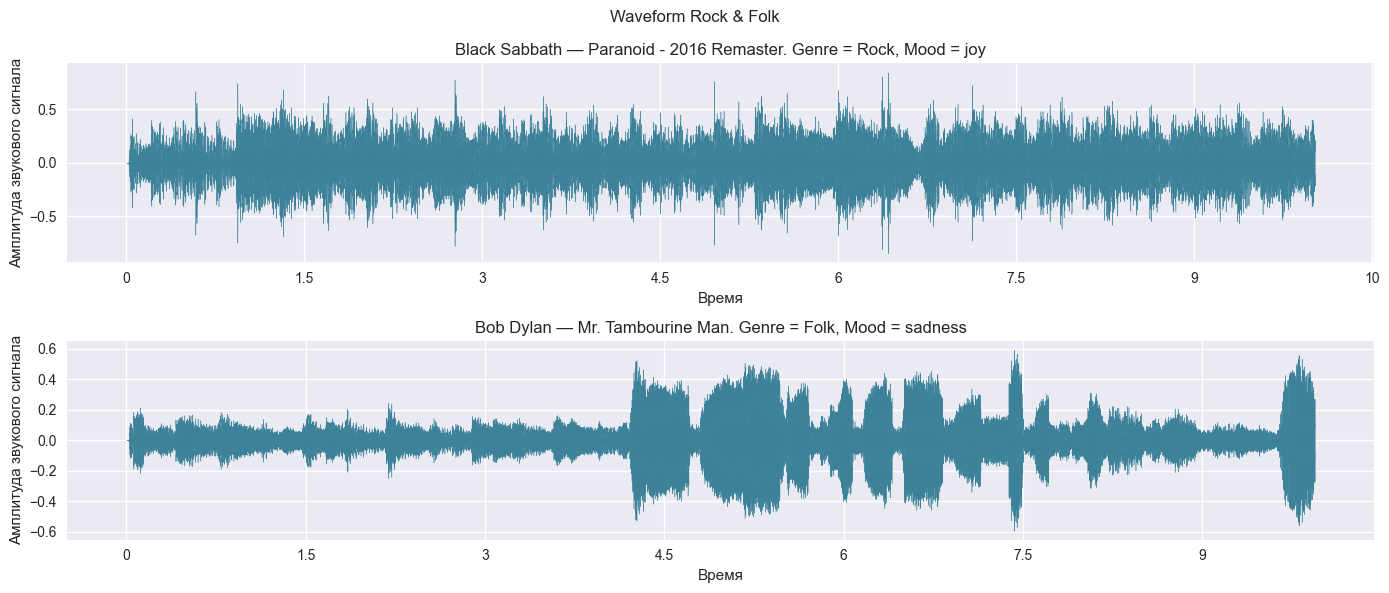

In [109]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))

librosa.display.waveshow(waveform_rock, sr=sr_rock, color="#3e8299", ax=ax1);
ax1.set_title(get_song_meta(rock_song))
ax1.set_xlabel('Время')
ax1.set_ylabel('Амплитуда звукового сигнала')

librosa.display.waveshow(waveform_folk, sr=sr_folk, color="#3e8299", ax=ax2);
ax2.set_title(get_song_meta(folk_song))
ax2.set_xlabel('Время')
ax2.set_ylabel('Амплитуда звукового сигнала')

plt.suptitle('Waveform Rock & Folk')
plt.tight_layout()

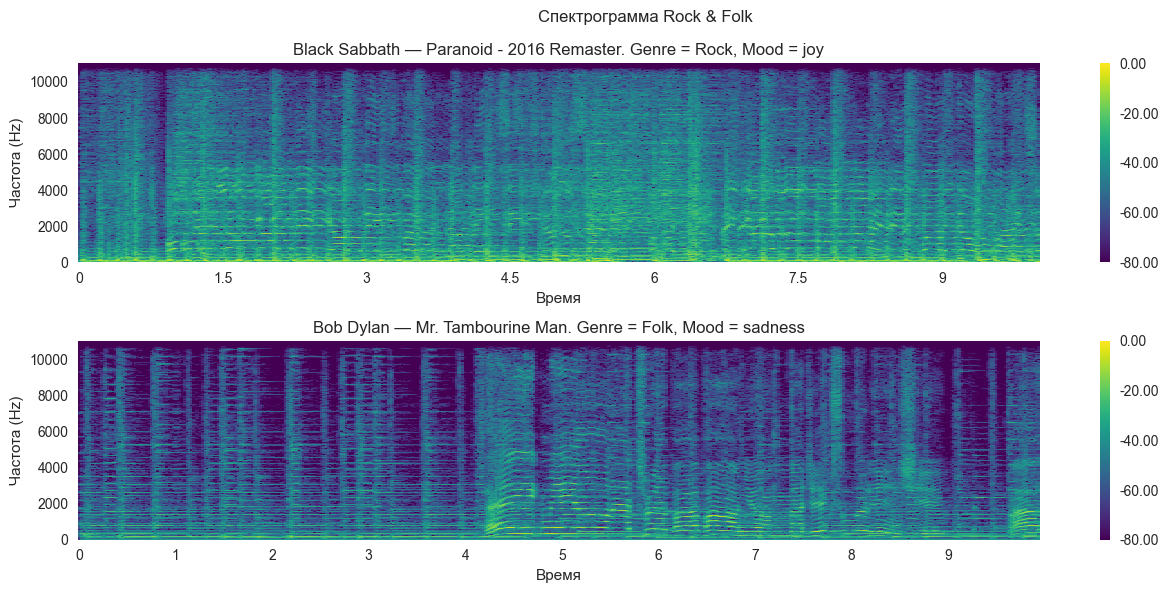

In [110]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13, 6))

S_db_rock = librosa.amplitude_to_db(np.abs(librosa.stft(waveform_rock)), ref=np.max)
S_db_folk = librosa.amplitude_to_db(np.abs(librosa.stft(waveform_folk)), ref=np.max)

img_rock = librosa.display.specshow(S_db_rock, x_axis='time', y_axis='hz', ax=ax1, sr=sr_rock, cmap='viridis')
ax1.set_title(get_song_meta(rock_song))
ax1.set_xlabel('Время')
ax1.set_ylabel('Частота (Hz)')
fig.colorbar(img_rock, ax=ax1, format=f'%0.2f')

img_folk = librosa.display.specshow(S_db_folk, x_axis='time', y_axis='hz', sr=sr_folk, ax=ax2, cmap='viridis')
ax2.set_title(get_song_meta(folk_song))
ax2.set_xlabel('Время')
ax2.set_ylabel('Частота (Hz)')
fig.colorbar(img_folk, ax=ax2, format=f'%0.2f')

plt.suptitle('Спектрограмма Rock & Folk')
plt.tight_layout()

Данные в этой спектрограмме линейны. Мы видим, как много пустых (или бледных) участков на спектрограмме в районе сверхвысоких частот (выше 8000 Гц). С такими данными неудобно работать, поэтому их часто преобразовывают в **MEL-шкалу**, которая является логарифмированной. Преобразование происходит по следующей формуле:

$$
m = 1127 \cdot \ln(1 + \frac{f}{700})
$$

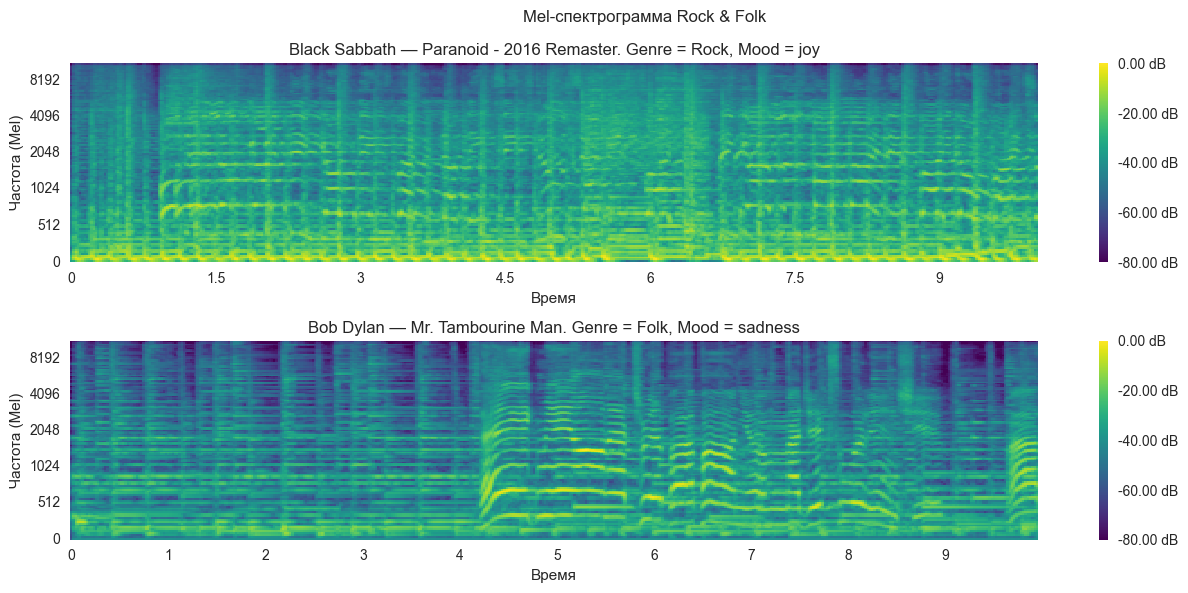

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13, 6))

logS_db_rock = librosa.power_to_db(librosa.feature.melspectrogram(y=waveform_rock, sr=sr_rock), ref=np.max)
logS_db_folk = librosa.power_to_db(librosa.feature.melspectrogram(y=waveform_folk, sr=sr_folk), ref=np.max)

img_rock = librosa.display.specshow(logS_db_rock, x_axis='time', y_axis='mel', ax=ax1, cmap='viridis')
ax1.set_title(get_song_meta(rock_song))
ax1.set_xlabel('Время')
ax1.set_ylabel('Частота (Mel)')
fig.colorbar(img_rock, ax=ax1, format=f'%0.2f dB')

img_folk = librosa.display.specshow(logS_db_folk, x_axis='time', y_axis='mel', ax=ax2, cmap='viridis')
ax2.set_title(get_song_meta(folk_song))
ax2.set_xlabel('Время')
ax2.set_ylabel('Частота (Mel)')
fig.colorbar(img_folk, ax=ax2, format=f'%0.2f dB')

plt.suptitle('Mel-спектрограмма Rock & Folk')
plt.tight_layout()

**MEL-шкала** создана, чтобы моделировать человеческое восприятие звуковых частот. Наш слух более чувствителен к низким и средним частотам (около 500–5000 Гц), чем к высоким. Человеческий слух воспринимает частоты **логарифмически**.

При создании MEL-спектрограммы интенсивность звукового сигнала преобразуется из линейной шкалы амплитуды в логарифмическую (децибелы). Логарифмическая шкала усиливает разницу между громкими и тихими звуками.

Теперь получим **MFCC**.

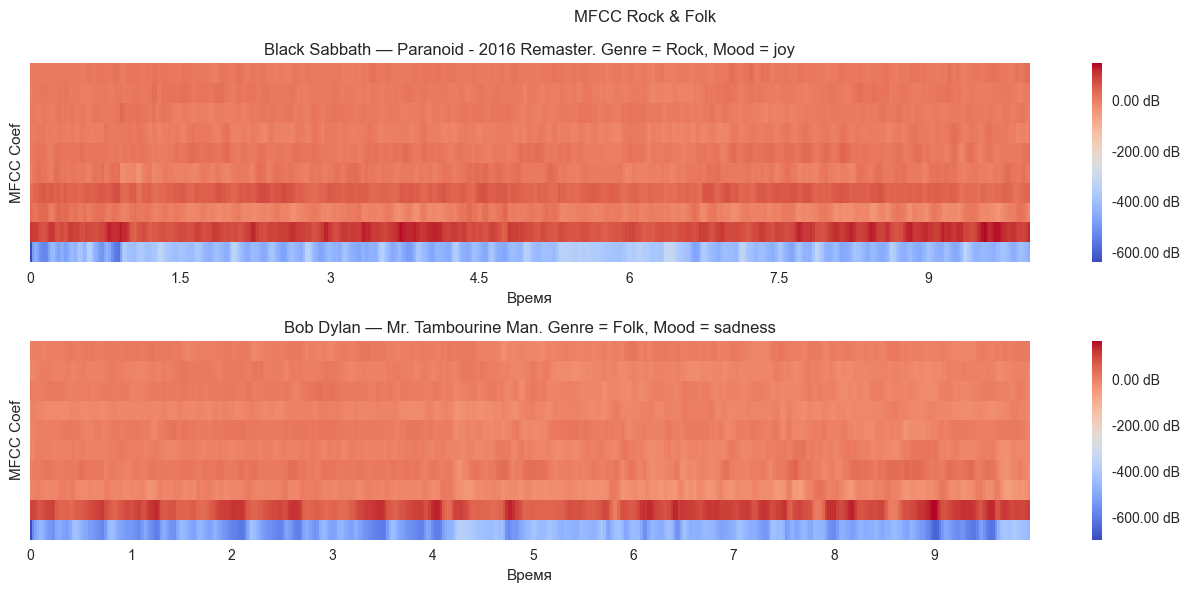

In [112]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13, 6))

mfccs_rock = librosa.feature.mfcc(S=logS_db_rock, sr=sr_rock, n_mfcc=10)
mfccs_folk = librosa.feature.mfcc(S=logS_db_folk, sr=sr_folk, n_mfcc=10)

img_rock = librosa.display.specshow(mfccs_rock, x_axis='time', ax=ax1)
ax1.set_title(get_song_meta(rock_song))
ax1.set_xlabel('Время')
ax1.set_ylabel('MFCC Coef')
fig.colorbar(img_rock, ax=ax1, format=f'%0.2f dB')

img_folk = librosa.display.specshow(mfccs_folk, x_axis='time', ax=ax2)
ax2.set_title(get_song_meta(folk_song))
ax2.set_xlabel('Время')
ax2.set_ylabel('MFCC Coef')
fig.colorbar(img_folk, ax=ax2, format=f'%0.2f dB')

plt.suptitle('MFCC Rock & Folk')
plt.tight_layout()

**MFCC** — это представление сигнала, грубо говоря, в виде особого спектра, из которого с помощью различных фильтраций и преобразований удалены незначительные для человеческого слуха компоненты. Спектр носит кратковременный характер, то есть изначально сигнал делится на пересекающиеся отрезки длиной 20-40 мс. Предполагается, что на таких отрезках частоты сигнала не меняются слишком сильно. И уже на этих отрезках и считаются волшебные коэффициенты.

### Классификация песен по жанрам на основе аудио-данных

Вернемся к изначальному датасету, где уже все данные собраны. Будем пытаться классифицировать песни по жанрам, основываясь на признаках аудиоданных.

In [85]:
mfcc_columns = sorted(low_level_audio_df.filter(regex='(MFCC_)', axis=1).columns, key=lambda x: int(x.split('_')[1]))
chroma_columns = sorted(low_level_audio_df.filter(regex='(Chroma_)').columns, key=lambda x: int(x.split('_')[1]))
mel_columns = sorted(low_level_audio_df.filter(regex='(MEL_)').columns, key=lambda x: int(x.split('_')[1]))
track_columns = ['track_id']

other_columns = genres_decade_tracks_df[['id', 'genre']]

df = pd.concat([
    low_level_audio_df[mfcc_columns],
    low_level_audio_df[chroma_columns],
    low_level_audio_df[mel_columns],
    low_level_audio_df[track_columns],
], axis=1).merge(other_columns, how='left', left_on='track_id', right_on='id').dropna().drop_duplicates(
    subset=['id']).drop(['track_id', 'id'], axis=1)

In [86]:
genre_value_counts = df['genre'].value_counts()
genres = genre_value_counts[genre_value_counts >= 300].index

df = df[df['genre'].isin(genres)]

In [87]:
X = df.drop('genre', axis=1)
y = df['genre']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [89]:
genres

Index(['Alternative', 'Rock', 'Dance', 'Folk', 'Pop', 'Blues'], dtype='object', name='genre')

In [113]:
models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial'),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "AdaBoost": AdaBoostClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name}: Средняя точность = {scores.mean():.4f} (+/-{scores.std():.4f})")

Logistic Regression: Средняя точность = 0.3417 (+/-0.0222)
Random Forest: Средняя точность = 0.3417 (+/-0.0120)
SVM: Средняя точность = 0.3215 (+/-0.0069)
AdaBoost: Средняя точность = 0.3319 (+/-0.0128)
DecisionTreeClassifier: Средняя точность = 0.2547 (+/-0.0152)


In [91]:
parameters = {
    'n_estimators': [100, 250, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 5, None],
}

rnd_forest = RandomForestClassifier()
clf = GridSearchCV(rnd_forest, parameters)

clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 5, None],
                         'n_estimators': [100, 250, 500]})

In [92]:
accuracy_score(y_test, clf.best_estimator_.predict(X_test))

0.3373913043478261

Получили довольно низкий результат. На то есть несколько причин:
- Данных мало
- Жанры, используемые для обучения, довольно похожие — Альтернативу и Рок может спокойно перепутать даже человек.
- Несмотря на различия жанров, с точки зрения аудио-характеристик у песен могут быть довольно похожие значения: спектрограмма инструментальной музыкой в одном жанре может быть похожа на пение с гитарой в другом жанре.
- Изначально неверная классификация (с погрешностью) жанров песен, полученных через кластеризацию

## Выводы

Исследование тенденций в музыке на основе разных данных позволило сделать следующие выводы: последние несколько десятков лет наблюдается стабильная тенденция в нарастающей громкости массовых песен, а также повышении числа песен, текст которых может содержать агрессию, а позитивные песни, наоборот — уменьшаются.

Для получения качественных результатов нужно больше данных, в идеале — собранных самостоятельно. Из этого вытекает наблюдение, что с использованием классический моделей классификация по аудиопризнакам в рамках моего датасета работает не очень хорошо. Чтобы улучшить результат, можно попробовать использовать рекуррентные нейросети.
Исходя из результатов работы, можно с уверенностью отметить, что сравнение трендов можно производить опираясь как на текст, так и на аудио-признаки.


## Список литературы

- Spotify API, — URL:
https://developer.spotify.com/documentation/web-api
- Speech Emotion Recognition Using Machine Learning, ISSN: 2148-2403, Prof. Kinjal S. Raja, Prof. Disha D. Sanghani
- Topic Modeling: Contextual Token Embeddings Are All You Need, Dimo Angelov, Diana Inkpen,  — URL:
https://aclanthology.org/2024.findings-emnlp.790.pdf
- Документация библиотеки Librosa, — URL:
https://librosa.org/doc/0.10.2/index.html
- Getting Started with Sentiment Analysis using Python, — URL:
https://huggingface.co/blog/sentiment-analysis-python
- MFCC’s Made Easy, — URL:
https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040
- Документация sklearn, — URL:
https://scikit-learn.org/
